#### Installing Necessary Pacakges

In [14]:
%reset -f
import importlib, subprocess, sys

def ensure(pkg, install_name=None):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", install_name or pkg]
        )
ensure("skfolio", "skfolio==0.15.2")
for p in ["numpy", "pandas", "matplotlib", "tqdm"]:
    ensure(p)

In [15]:
from skfolio.optimization import MeanRisk, ObjectiveFunction
from skfolio.moments import EmpiricalCovariance, LedoitWolf
from skfolio import RiskMeasure
from skfolio.prior import EmpiricalPrior
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm

### Data Processing

In [16]:
fx_raw = pd.read_csv("FX_rates.csv")

currency_row = fx_raw.iloc[0, 1:].values
fx = fx_raw.iloc[1:].copy()
fx["Time Period"] = pd.PeriodIndex(fx["Time Period"], freq="M")
fx = fx.set_index("Time Period")
fx = fx.apply(pd.to_numeric, errors="coerce")


fx_adj = fx.copy()
for col, curr in zip(fx.columns, currency_row):
    if curr != "USD":
        fx_adj[col] = 1.0 / fx_adj[col]

delta_s = np.log(fx_adj).diff().dropna(how="all").round(6)

rf_raw = pd.read_csv("Risk Free Rates.csv")
currency_to_country = {
    "USD": "USD",
    "AUD": "AUSTRALIA", "CAD": "CANADA", "EUR": "EURO AREA",
    "BRL": "BRAZIL", "CHF": "SWITZERLAND", "DKK": "DENMARK",
    "GBP": "UNITED KINGDOM", "JPY": "JAPAN", "KRW": "KOREA",
    "ZAR": "SOUTH AFRICA", "TWD": "TAIWAN", "SGD": "SINGAPORE",
    "NZD": "NEW ZEALAND", "MXN": "MEXICO", "NOK": "NORWAY",
    "INR": "INDIA", "CNY": "CHINA", "SEK": "SWEDEN","HUF":"HUNGARY",
    "CZK":"CZECHIA","TRY":"TURKEY"
}
rf = rf_raw.rename(columns=currency_to_country)

fx_countries = delta_s.columns
for country in fx_countries:
    if country not in rf.columns:
        rf[country] = np.nan

rf["Time Period"] = pd.to_datetime(rf["Time Period"], format="%Y%m%d", errors='coerce')
rf = rf.set_index("Time Period")
rf = rf.apply(pd.to_numeric, errors="coerce")

rf_monthly = rf.resample('ME').mean().round(6) /12
rf_monthly.index = rf_monthly.index.to_period("M")


common_index = delta_s.index.intersection(rf_monthly.index)
delta_s = delta_s.loc[common_index]
rf_monthly = rf_monthly.loc[common_index]

usd_rf = rf_monthly["USD"]

excess_returns = pd.DataFrame(index=common_index, columns=delta_s.columns, dtype=float)

for col in delta_s.columns:
    if col not in rf_monthly.columns:
        continue

    mask = delta_s[col].notna() & rf_monthly[col].notna() & usd_rf.notna()
    excess_returns.loc[mask, col] = rf_monthly.loc[mask, col] - usd_rf.loc[mask] - delta_s.loc[mask, col]

excess_returns.round(6).drop(["INDIA", "CHINA", "KOREA"], axis=1).to_csv("FX_excess_returns.csv", na_rep="NaN")

In [17]:
df = pd.read_csv("FX_excess_returns.csv")

df["Time Period"] = pd.to_datetime(df["Time Period"])
df = df.set_index("Time Period")

returns = df.astype(float)

### Rolling-window out-of-sample framework

In [18]:
WINDOW = 120  # rolling window length (5 years)
n_assets = returns.shape[1]
assets = returns.columns

rf = pd.Series(0.0, index=returns.index)

oos_returns = {
    "Markowitz based on Sample Estimates": [],
    "Naive Equally Weighted": [],
    "Markowitz based on Shrinkage": [],
    "Constrained": [],
    "Resampling-based Estimation": []
}

oos_dates = []

### In-sample benchmark: Tangency portfolio (Markowitz)

Benchmark Weights:
 AUSTRALIA         0.378857
EURO AREA        -0.907557
NEW ZEALAND      -0.069747
UNITED KINGDOM   -0.547914
BRAZIL           -0.373107
CANADA            0.676585
DENMARK           0.654150
JAPAN            -0.628160
MEXICO           -0.503809
NORWAY           -0.320905
SOUTH AFRICA     -0.222835
SINGAPORE         2.792057
SWEDEN           -0.067704
SWITZERLAND       0.254292
TAIWAN            0.213458
TURKEY           -0.477734
CZECHIA           0.808959
HUNGARY          -0.658884
dtype: float64


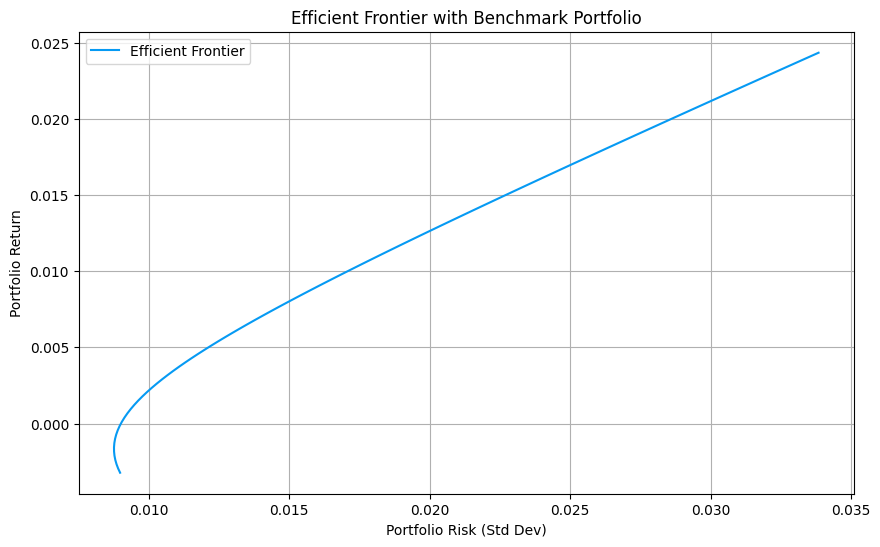

Benchmark Return: -0.030823229824515505
Benchmark Risk: 0.03769482859639179


In [19]:
assets = returns.columns
n_assets = len(assets)

mu_hat = returns.mean().values
Sigma_hat = EmpiricalCovariance().fit(returns.values).covariance_

inv_Sigma = np.linalg.inv(Sigma_hat)
ones = np.ones(n_assets)

w_is = inv_Sigma @ mu_hat / (ones @ inv_Sigma @ mu_hat)
benchmark_weights = pd.Series(w_is, index=assets)
print("Benchmark Weights:\n", benchmark_weights)

A = ones @ inv_Sigma @ ones
B = ones @ inv_Sigma @ mu_hat
C = mu_hat @ inv_Sigma @ mu_hat
D = A*C - B**2

target_returns = np.linspace(mu_hat.min(), mu_hat.max(), 100)
# target_returns = np.append(target_returns, w_is @ mu_hat)
frontier_risks = []

for R in target_returns:
    w = ((C - B*R)/D) * (inv_Sigma @ ones) + ((A*R - B)/D) * (inv_Sigma @ mu_hat)
    sigma = np.sqrt(w @ Sigma_hat @ w)
    frontier_risks.append(sigma)

bench_return = w_is @ mu_hat
bench_risk = np.sqrt(w_is @ Sigma_hat @ w_is) 

plt.figure(figsize=(10,6))
plt.plot(frontier_risks, target_returns, label='Efficient Frontier', color='#069AF3')
# plt.scatter(bench_risk, bench_return, color='red', marker='*', s=200, label='Benchmark (Tangency)')
plt.xlabel('Portfolio Risk (Std Dev)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier with Benchmark Portfolio')
plt.legend()
plt.grid(True)
plt.show()

print("Benchmark Return:", bench_return)
print("Benchmark Risk:", bench_risk)

#### Short Selling Constraint
Change Short_selling to False for no short selling. Restart the Jupyter Notebook before running the code always to clear the Jupyter variables.

In [20]:
short_selling = True
if short_selling:
    weight_constraint_max = None
    weight_constraint_min = None
    plot_col = "tab20c"
    tag = "SS"
else:
    weight_constraint_max = 1
    weight_constraint_min = 0
    plot_col = "tab20"
    tag = "NSS"

### Optimization Methods

In [21]:
threshold = 1e-10
round_off = 8

oos_weights = {
    "Markowitz based on Sample Estimates": [],
    "Naive Equally Weighted": [],
    "Markowitz based on Shrinkage": [],
    "Constrained": [],
    "Resampling-based Estimation": []
}

for t in tqdm(range(WINDOW, len(returns) - 1), desc="OOS Loop"):

    train = returns.iloc[t-WINDOW:t]
    test = returns.iloc[t+1]
    oos_dates.append(returns.index[t+1])

    # ---------------- Markowitz ----------------
    mv = MeanRisk(
        risk_measure=RiskMeasure.VARIANCE,
        objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
        min_weights=weight_constraint_min,
        max_weights=weight_constraint_max,
    )   
    
    mv.fit(train.values)   
    w_mv = mv.weights_
    w_mv[np.abs(w_mv) < threshold] = 0       
    w_mv = np.round(w_mv, round_off)                  
    oos_returns["Markowitz based on Sample Estimates"].append(np.dot(w_mv, test.values))
    oos_weights["Markowitz based on Sample Estimates"].append(w_mv)

    # ---------------- Equal Weight ----------------
    w_eq = np.ones(n_assets) / n_assets
    w_eq[np.abs(w_eq) < threshold] = 0
    w_eq = np.round(w_eq, round_off)
    oos_returns["Naive Equally Weighted"].append(np.dot(w_eq, test.values))
    oos_weights["Naive Equally Weighted"].append(w_eq)

    # ---------------- Shrinkage ----------------
    mv_shrink = MeanRisk(
        risk_measure=RiskMeasure.VARIANCE,
        prior_estimator=EmpiricalPrior(covariance_estimator=LedoitWolf()),
        objective_function= ObjectiveFunction.MAXIMIZE_RATIO,
        min_weights=weight_constraint_min,
        max_weights=weight_constraint_max
    )
    mv_shrink.fit(train.values)
    w_shrink = mv_shrink.weights_
    w_shrink[np.abs(w_shrink) < threshold] = 0
    w_shrink = np.round(w_shrink, round_off)
    oos_returns["Markowitz based on Shrinkage"].append(np.dot(w_shrink, test.values))
    oos_weights["Markowitz based on Shrinkage"].append(w_shrink)

    # ---------------- Constrained ----------------
    mv_const = MeanRisk(
        risk_measure=RiskMeasure.VARIANCE,
        objective_function=ObjectiveFunction.MAXIMIZE_UTILITY,
        risk_aversion=1,
        min_weights= -0.10,
        max_weights= 0.40
    )
    mv_const.fit(train.values)
    w_const = mv_const.weights_
    w_const[np.abs(w_const) < threshold] = 0
    w_const = np.round(w_const, round_off)
    oos_returns["Constrained"].append(np.dot(w_const, test.values))
    oos_weights["Constrained"].append(w_const)

    # ---------------- Resampled ----------------
    B = 60
    weights_boot = np.zeros((B, n_assets))
    np.random.seed(123)   # For Reproducibility
    for b in range(B):
        idx = np.random.choice(WINDOW, size=WINDOW, replace=True)
        boot_sample = train.iloc[idx]
        mv_boot = MeanRisk(
            risk_measure=RiskMeasure.VARIANCE,
            objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
            max_weights=weight_constraint_max,
            min_weights=weight_constraint_min
        )
        mv_boot.fit(boot_sample.values)
        weights_boot[b, :] = mv_boot.weights_
    w_resampled = weights_boot.mean(axis=0)
    w_resampled[np.abs(w_resampled) < threshold] = 0
    w_resampled = np.round(w_resampled, round_off)
    oos_returns["Resampling-based Estimation"].append(np.dot(w_resampled, test.values))
    oos_weights["Resampling-based Estimation"].append(w_resampled)

weights_dfs = {strategy: pd.DataFrame(oos_weights[strategy], index=oos_dates, columns=assets)
               for strategy in oos_weights.keys()}

for strategy, df_w in weights_dfs.items():
    df_w.to_csv(f"{strategy}_weights_{tag}.csv")

OOS Loop: 100%|██████████| 112/112 [00:30<00:00,  3.72it/s]


#### Convert out-of-sample returns to DataFrame

In [22]:
oos_df = pd.DataFrame(oos_returns, index=oos_dates)
oos_df.to_csv(f"oos_returns_{tag}.csv", index=True)

#### Sharpe ratios - Final results table (benchmarking)

In [23]:
sharpe_table = (
    (oos_df.mean() * 12) / (oos_df.std() * np.sqrt(12))
).to_frame("Annualized Out-of-Sample Sharpe Ratio") \
 .sort_values(by="Annualized Out-of-Sample Sharpe Ratio", ascending=False)

sharpe_table

,Annualized Out-of-Sample Sharpe Ratio
Constrained,1.992674
Naive Equally Weighted,0.892978
Resampling-based Estimation,-0.513243
Markowitz based on Shrinkage,-1.179972
Markowitz based on Sample Estimates,-1.463963


### Plots

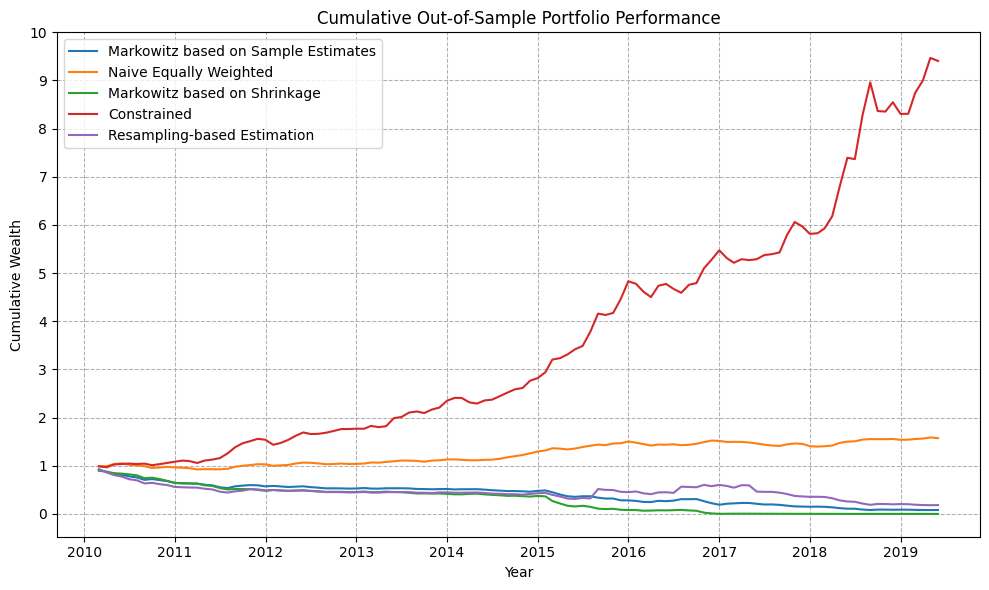

In [24]:
cum_returns = (1 + oos_df).cumprod()

plt.figure(figsize=(10, 6))
for col in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[col], label=col)

plt.legend()
plt.title("Cumulative Out-of-Sample Portfolio Performance")
plt.xlabel("Year")
plt.ylabel("Cumulative Wealth")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
y_max = int(cum_returns.max().max()) + 1
plt.yticks(range(0, y_max + 1, 1))
plt.tight_layout()
plt.grid(True,linestyle='--',linewidth=0.75)
plt.savefig(f"cum_wealth_{tag}.png", dpi=300, bbox_inches="tight")
plt.show()

### Bar Plots for weights of the countries

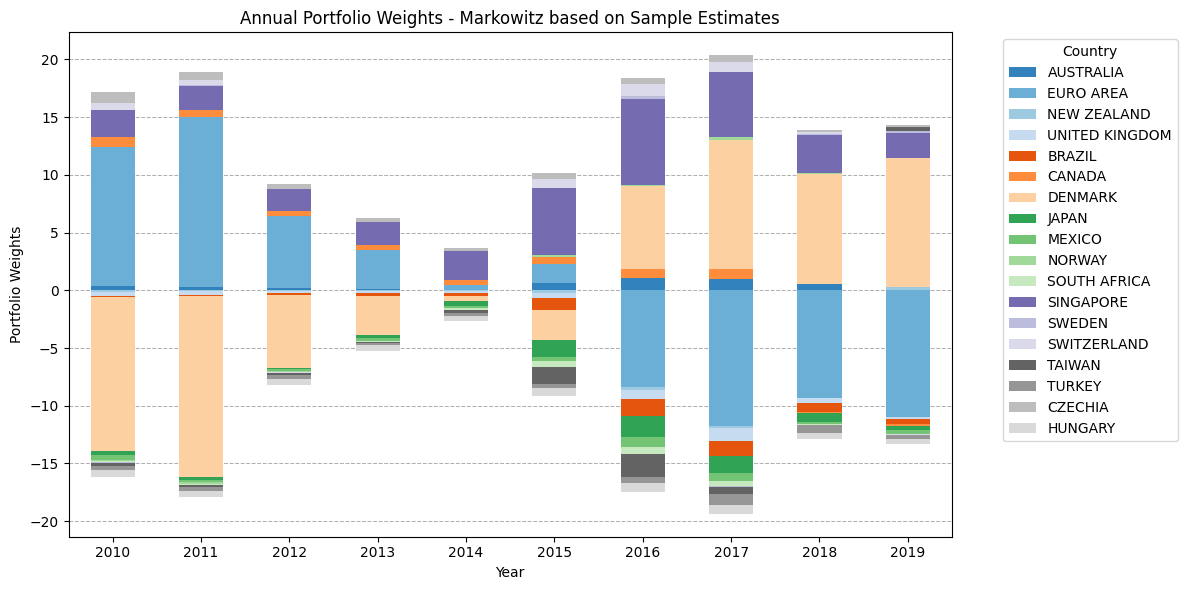

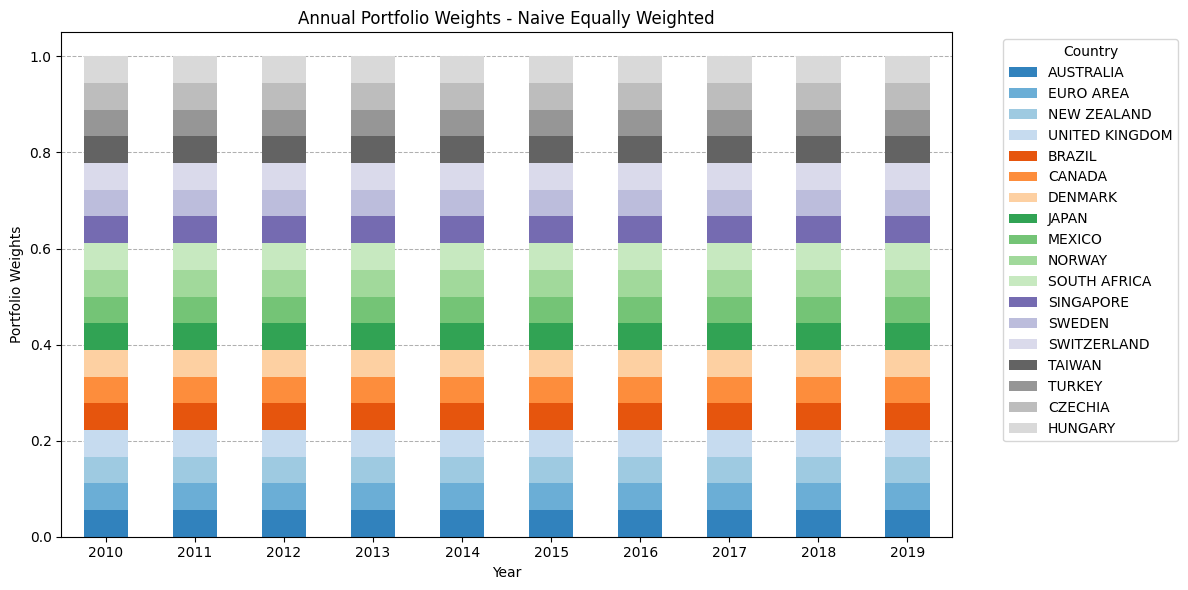

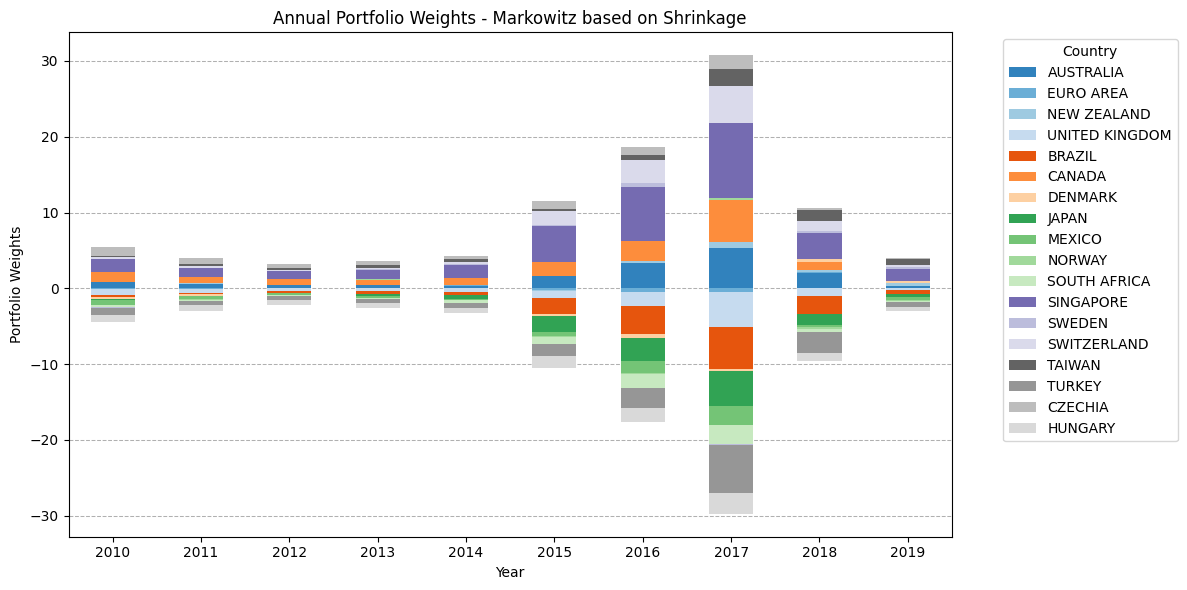

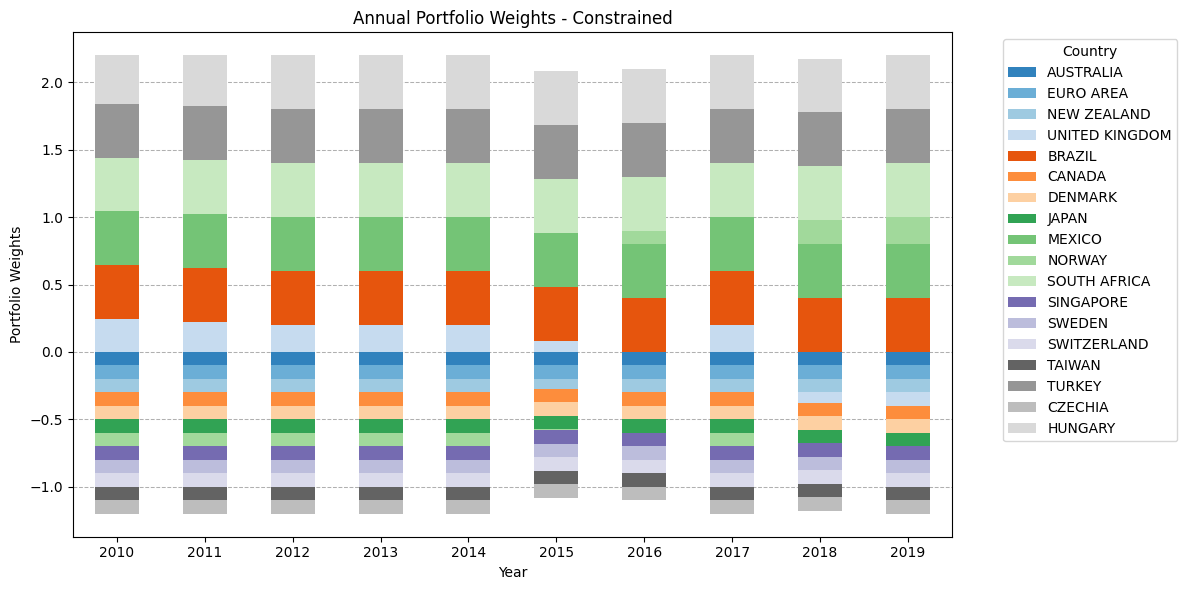

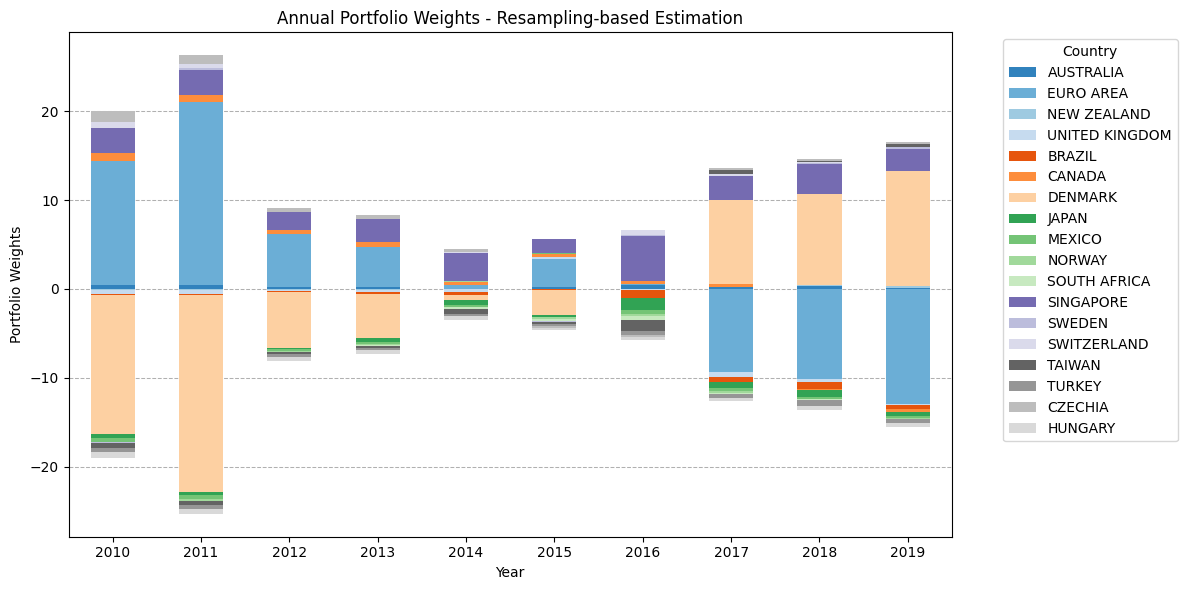

In [25]:
for strategy, weights_df in weights_dfs.items():
    df = weights_df.copy()
    
    df['Year'] = df.index.year
    annual_weights = df.groupby('Year').mean()
    annual_weights = annual_weights.drop(columns=['Year'], errors='ignore')

    fig, ax = plt.subplots(figsize=(12, 6))

    annual_weights.plot(
        kind='bar',
        stacked=True,
        colormap=plot_col,
        zorder=2,
        ax=ax
    )

    ax.grid(axis='y', linestyle='--', linewidth=0.75, zorder=1)
    ax.set_ylabel("Portfolio Weights")
    ax.set_xlabel("Year")
    ax.set_title(f"Annual Portfolio Weights - {strategy}")
    ax.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.tight_layout()
    plt.savefig(f"{strategy}_{tag}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

### Rolling Sharpe Plots

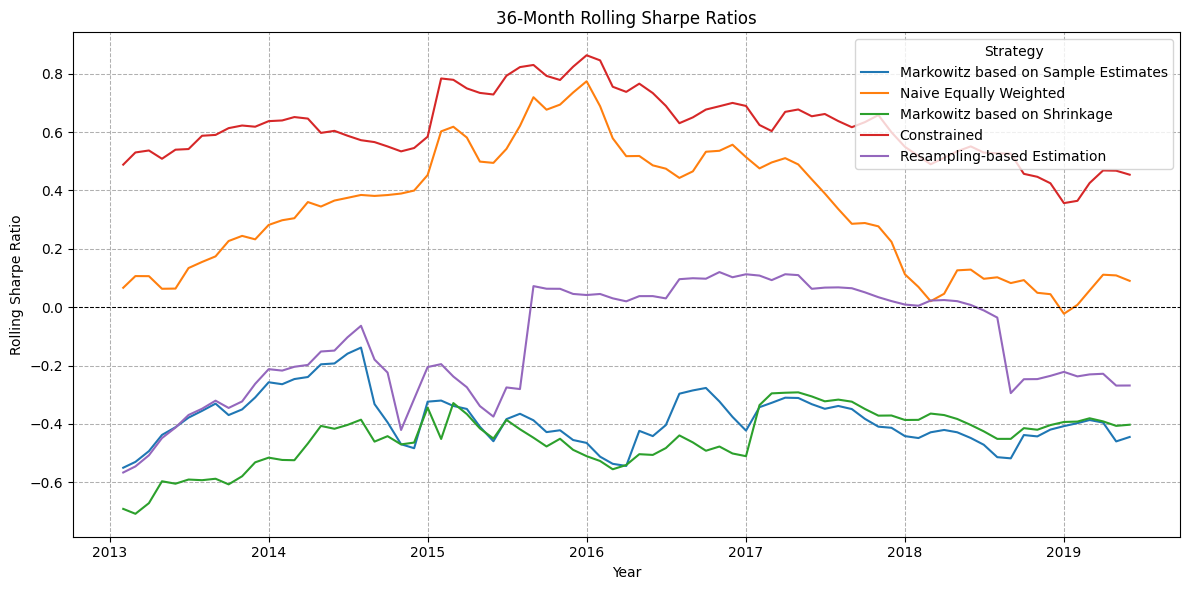

In [26]:
oos_df = pd.DataFrame(oos_returns, index=pd.to_datetime(oos_dates).to_period('M'))

start_period = oos_df.index.min()
rf_usd_aligned = rf_monthly["USD"].loc[start_period:]

if not isinstance(rf_usd_aligned.index, pd.PeriodIndex):
    rf_usd_aligned.index = rf_usd_aligned.index.to_period('M')

rf_usd_aligned = rf_usd_aligned.reindex(oos_df.index).ffill()
excess_returns = oos_df.subtract(rf_usd_aligned, axis=0)

rolling_window = 36
rolling_sharpe = excess_returns.rolling(window=rolling_window).mean() / \
                 excess_returns.rolling(window=rolling_window).std()
rolling_sharpe = rolling_sharpe.dropna(how='all')

plt.figure(figsize=(12,6))
for col in rolling_sharpe.columns:
    # Convert PeriodIndex to datetime for matplotlib
    plt.plot(rolling_sharpe.index.to_timestamp(), rolling_sharpe[col], label=col)

plt.axhline(0, color='black', linestyle='--', linewidth=0.75)
plt.title(f"{rolling_window}-Month Rolling Sharpe Ratios")
plt.ylabel("Rolling Sharpe Ratio")
plt.xlabel("Year")
plt.grid(True, linestyle='--', linewidth=0.75)
plt.legend(title="Strategy")
plt.tight_layout()
plt.savefig(f"sharpe_ratio_{tag}.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


--------
##### Author: Hema Srikar Ankem

No part of the above program is generated using AI. It was written with the aid of documentation of all python packages used in this Jupyter Notebook
